In [ ]:
from glob import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import torch.optim as optim
import torch.nn.functional as Fun
import pandas as pd



from google.colab import drive
drive.mount('/content/gdrive')
import os

# clean ds
CLEAN_DS_PATH = '/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart'

# train
CLEAN_TRAIN_PATH = f'{CLEAN_DS_PATH}/train'
CLEAN_TRAIN_IMG_PATH = f'{CLEAN_TRAIN_PATH}/images'
CLEAN_TRAIN_MSK_PATH = f'{CLEAN_TRAIN_PATH}/masks'
print(CLEAN_TRAIN_IMG_PATH)
# val
CLEAN_VAL_PATH = f'{CLEAN_DS_PATH}/val'
CLEAN_VAL_IMG_PATH = f'{CLEAN_VAL_PATH}/images'
CLEAN_VAL_MSK_PATH = f'{CLEAN_VAL_PATH}/masks'


# MAking dataset ready
class SimpleLogger:

    def __init__(self, debug=True):
        self.debug = debug

    def enable_debug(self):
        self.debug = True

    def disable_debug(self):
        self.debug = False

    def log(self, message, condition=True):
        if self.debug and condition:
            print(message)


logger = SimpleLogger(debug=True)

def to_categorical(y, n_classes):
    return np.eye(n_classes, dtype="uint8")[y]


class BraTSDataset(Dataset):
    def log(self, message):
        logger.log(message, condition=self.debug)

    def __init__(self, images_path, masks_path, transform=None, one_hot_target=True, debug=True):
              
        self.images = sorted(glob(f"{images_path}/*.npy"))
        self.masks = sorted(glob(f"{masks_path}/*.npy"))
        self.transform = transform
        self.one_hot_target = one_hot_target
        self.debug = debug
        self.log(f"images: {len(self.images)}, masks: {len(self.masks)} ")
        assert len(self.images) == len(self.masks), "images and masks lengths are not the same!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        image = np.load(self.images[idx])
        mask = np.load(self.masks[idx])
        # resizing image and mask, experimental
        image = image[::2,::2,::2]
        mask = mask[::2,::2,::2]
        if self.one_hot_target:
            mask = to_categorical(mask, 4)
            mask = mask[::, ::, ::, 1::]  # discard background

        image = torch.from_numpy(image).float()  # .double()
        mask = torch.from_numpy(mask)  # .float() #.long()

        return image.permute((3, 0, 1, 2)), mask.permute((3, 0, 1, 2))


def get_dl(dataset, batch_size=4, pm=True, nw=1):
    return DataLoader(dataset, batch_size, shuffle=False, pin_memory=pm, num_workers=nw, ) # change

def get_train_ds():
    return BraTSDataset(CLEAN_TRAIN_IMG_PATH, CLEAN_TRAIN_MSK_PATH)


def get_val_ds():
    return BraTSDataset(CLEAN_VAL_IMG_PATH, CLEAN_VAL_MSK_PATH)


# this is for testing only
# if __name__ == '__main__':
#     train_ds = BraTSDataset(CLEAN_TRAIN_IMG_PATH, CLEAN_TRAIN_MSK_PATH)
#     print(train_ds[0][0].shape)
#     print(train_ds[0][1].shape)
#     dl = get_dl(train_ds, batch_size=1)
#     print("OK")


Mounted at /content/gdrive
/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart/train/images


In [ ]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Attention 3DUNet

class DoubleConv3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 1 + (L - l + 2P)/s
        self.conv = nn.Sequential(
            # 1 + out - 3 + 2 = out
            nn.Conv3d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.conv(inputs)

class Base3DUNet(nn.Module):
    # the default dataset has 3 channels of data ->  T1CE, T2, FLAIR
    # The output has background, NCR/NET, ED, ET
    def __init__(self, in_channels=3, out_channels=4, features=[64, 128, 256, 512], up_sample=False):
        super().__init__()
        # 1 + (L - l + 2P)/s
        # 1 + (L - 2)/2 = L
        self.pooling = nn.MaxPool3d(kernel_size=2, stride=2)

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Each Layer - number of filters , see UNet architecture
        input_channels = in_channels

        for feature in features:
            self.downs.append(DoubleConv3D(input_channels, feature))
            input_channels = feature

        for feature in reversed(features):
            if up_sample:
                self.ups.append(nn.Upsample(scale_factor=2, mode="trilinear", align_corners=True))
                self.ups.append(DoubleConv3D(feature * 3, feature))
                # *3 because upsample does not change the number of channels
            else:
                self.ups.append(nn.ConvTranspose3d(feature * 2, feature, kernel_size=2, stride=2))
                self.ups.append(DoubleConv3D(feature * 2, feature))

        self.bottleneck = DoubleConv3D(features[-1], features[-1] * 2)  # this connects downs to ups

        self.output_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)  # last layer - feature compression

    def forward(self, inputs):
        skips = []

        x = inputs
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pooling(x)

        x = self.bottleneck(x)

        for idx in range(0, len(self.ups), 2):  # going up 2 steps, as each step has convTranspose and DoubleConv
            x = self.ups[idx](x)  # up sampling w/ the convTranspose
            skip_connection = skips.pop()  # give me the last skip I added, to add it first on the ups
            x = torch.cat((skip_connection, x), dim=1)  # dim 0 is batch, dim 1 is the channels
            x = self.ups[idx + 1](x)  # double conv

        return self.output_conv(x)

class AttentionBlock(nn.Module):
    # Xs come from the encoder and Gs come from previous lower layer and a point-wise conv is applied to both and
    # their sum will be calculated and fed into ReLU Then another point-wise conv (Psi) is applied with a sigmoid after
    # that, which is supposed to be the probability map of each data point (pixel) hence it is multiplied with the X

    # Why we don't multiply it with G?
    # My Intuition: because more information will be available in X and its size is closer to the current module
    # if G is used then we need rescaling or padding, which makes it useless, on the other hand we already have the
    # effect of both
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0), nn.BatchNorm3d(F_int))
        self.W_x = nn.Sequential(nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0), nn.BatchNorm3d(F_int))
        self.psi = nn.Sequential(nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0), nn.BatchNorm3d(1))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g = self.W_g(g)
        x_o = self.W_x(x)
        relu_sum = self.relu(g + x_o)
        psi = self.psi(relu_sum)
        psi = torch.sigmoid(psi)
        return x * psi


class Attention3UNet(Base3DUNet):  # Generalization of 2D attention UNet
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512], up_sample=True):
        super().__init__(in_channels, out_channels, features, up_sample=up_sample)
        self.attention = nn.ModuleList()

        for feature in reversed(features):
            if up_sample:
                self.attention.append(AttentionBlock(feature * 2, feature, feature))
            else:
                self.attention.append(AttentionBlock(feature, feature, feature))
                # when convT is used, then the G is normal and the same as skip

    def forward(self, inputs):
        skips = []

        x = inputs
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pooling(x)

        x = self.bottleneck(x)

        # same as original Unet till here

        for idx in range(0, len(self.ups), 2):  # going up 2 steps, as each step has convTranspose and DoubleConv
            x = self.ups[idx](x)  # up sampling w/ the convTranspose or Upsampler

            # ---> DIFF START: the skip_connection acquired is the X_l in attention UNet paper, and x is G
            skip_connection = skips.pop()  # give me the last skip I added, to add it first on the ups
            skip_connection = self.attention[idx // 2](x, skip_connection)  # (G,X) = (x, skip_connection) in here
            # <---- end of difference between attention and base 3D UNet

            x = torch.cat((skip_connection, x), dim=1)  # dim 0 is batch, dim 1 is the channels
            x = self.ups[idx + 1](x)  # double conv

        return self.output_conv(x)


In [ ]:
# Extract training and validation masks for the second part of the project
# For training and validation of the second part, I need masks. Because I want to extract the volume of the tumour and use it for the training and validation part.
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_dataset(data_loader, model, device="cuda"):
    preds_masks = torch.empty((0, 3, 64, 64, 64)).to(device)
    x_images = torch.empty((0, 3, 64, 64, 64)).to(device)
    y_masks = torch.empty((0, 3, 64, 64, 64)).to(device)
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device) #.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            preds_masks = torch.cat((preds_masks, preds), dim=0)
            y_masks = torch.cat((y_masks, y), dim=0)
            x_images =  torch.cat((x_images, x), dim=0)
            # print(preds.shape)
            # print(preds_masks.shape)
    model.train()
    return preds_masks, x_images, y_masks


# For the training part, I load all the masks in the database (actual masks)
print("Number of training images:")
BATCH_SIZE = 4;
train_dl = get_dl(get_train_ds(), BATCH_SIZE, nw=1)
train_masks_y = torch.empty((0, 3, 64, 64, 64)).to(device)
train_images_x = torch.empty((0, 3, 64, 64, 64)).to(device)
for x, y in train_dl:
    x = x.to(device)
    y = y.to(device) #.unsqueeze(1)
    train_masks_y = torch.cat((train_masks_y, y), dim=0)
    train_images_x =  torch.cat((train_images_x, x), dim=0)
#print(train_masks_y.shape)


# For the validation part, first, I give all the validation images to the 3DUNET and get the masks and then use these masks to compute the tumour volume for the survival days prediction
# 1) Loading test dataset
print("Number of testing images:")
val_dl = get_dl(get_val_ds(), BATCH_SIZE, nw=1)

# 1) Loading 3DUNET model
model = Attention3UNet(3, 3, features=[64, 128, 256, 512], up_sample=False).to(DEVICE)

path = "/content/gdrive/MyDrive/ProjectDL/BraTS/att3d_100e_adam_b4_bce_dice_c"
model.load_state_dict(torch.load(f"{path}.pt"))
model.eval()

# 3) Geting output of the model
test_masks_preds = load_dataset(val_dl,model,DEVICE)[0] 
test_images_x = load_dataset(val_dl,model,DEVICE)[1]
#print(test_images_x.shape[-1])





# Calculate the ratios of the volume of each tumor sub-region to the size of the whole brain. 
# Train ratios
num_wholebrain_volume = np.zeros((train_masks_y.shape[0], 3))
num_tumor_volume = np.zeros((train_masks_y.shape[0], 3))
train_ratios = np.zeros((train_masks_y.shape[0], 3))
# Loop over all train masks
for i in range(train_masks_y.shape[0]):
    for j in range(train_masks_y.shape[1]):
        # calculate the size of the whole brain
        num_wholebrain_volume[i,j] += (train_images_x[i, 0, :, :, :] == 0).sum()  # I just want to use T1Gd for calculating the volume of the brain 
        num_wholebrain_volume[i,j] = (train_images_x.shape[-1]*train_images_x.shape[-1]*train_images_x.shape[-1]) - num_wholebrain_volume[i,j]

        # calculate the the volume of each tumor sub-region to the size of the whole brain.
        num_tumor_volume[i,j] += (train_masks_y[i, j, :, :, :] != 0).sum() 
        #print(num_tumor_volume[i,j])
    
        # the ratios of the volume of each tumor sub-region to the size of the whole brain
        train_ratios[i, j] = num_tumor_volume[i,j] / num_wholebrain_volume[i,j]


train_age = pd.read_csv('/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart/train/survival_age.csv', header=None)
# train_dataset_sd = np.concatenate(((train_ratios), (train_age)), axis=1)

train_dataset_sd = np.zeros((train_age.shape[0], 6))
train_dataset_sd[:,0] = train_age.iloc[:,0]
train_dataset_sd[:,1] = train_ratios[:,0] 
train_dataset_sd[:,2] = train_ratios[:,1]  
train_dataset_sd[:,3] = train_ratios[:,2] 
train_dataset_sd[:,4] = train_ratios[:,0] + train_ratios[:,2] # TC
train_dataset_sd[:,5] = train_ratios[:,0] + train_ratios[:,1] + train_ratios[:,2] # WT

train_dataset_sd_mean = np.mean(train_dataset_sd, axis= 0)
train_dataset_sd_std = np.std(train_dataset_sd, axis=0)
train_dataset_sd = (((train_dataset_sd - train_dataset_sd_mean) / train_dataset_sd_std) + 1) / 2
print("Size of the training matrix after adding age feature. (3 tomour volumes and one age feature)")
print(train_dataset_sd.shape)

train_survival_days = pd.read_csv('/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart/train/survival_days_category.csv', header=None)
# one hot
train_survival_days_onehot = Fun.one_hot(torch.from_numpy(train_survival_days.values), num_classes = 3)
train_label_sd = train_survival_days_onehot
train_label_sd = torch.squeeze(train_label_sd)
# not one hot
# train_label_sd = torch.squeeze(torch.from_numpy(train_survival_days.values))

train_data_sd = []
for i in range(len(train_dataset_sd)):
   train_data_sd.append([train_dataset_sd[i], train_label_sd[i]])


# Test ratios
num_wholebrain_volume = np.zeros((test_masks_preds.shape[0], 3))
num_tumor_volume = np.zeros((test_masks_preds.shape[0], 3))
test_ratios = np.zeros((test_masks_preds.shape[0], 3))
# Loop over all train masks
for i in range(test_masks_preds.shape[0]):
    for j in range(test_masks_preds.shape[1]):
        # Count the number of elements in the current mask
        num_wholebrain_volume[i,j] += (test_images_x[i, 0, :, :, :] == 0).sum()   # I just want to use T1Gd for calculating the volume of the brain 
        num_wholebrain_volume[i,j] = (test_images_x.shape[-1]*test_images_x.shape[-1]*test_images_x.shape[-1]) - num_wholebrain_volume[i,j]
        #print(num_wholebrain_volume[i,j])

        # Count the number of elements with value 3 in the current image
        num_tumor_volume[i,j] += (test_masks_preds[i, j, :, :, :] != 0).sum() # torch.count_nonzero(torch.numel(train_masks_y[i, j, :, :, :]) 
        #print(num_tumor_volume[i,j])
    
        # Calculate the ratio of elements 
        test_ratios[i, j] = num_tumor_volume[i,j] / num_wholebrain_volume[i,j]


test_age = pd.read_csv('/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart/val/survival_age.csv', header=None)
# test_dataset_sd = np.concatenate(((test_ratios), (test_age)), axis=1)

test_dataset_sd = np.zeros((test_age.shape[0], 6))
test_dataset_sd[:,0] = test_age.iloc[:,0]
test_dataset_sd[:,1] = test_ratios[:,0] 
test_dataset_sd[:,2] = test_ratios[:,1]  
test_dataset_sd[:,3] = test_ratios[:,2]  # ET
test_dataset_sd[:,4] = test_ratios[:,0] + test_ratios[:,2] # TC
test_dataset_sd[:,5] = test_ratios[:,0] + test_ratios[:,1] + test_ratios[:,2] # WT


test_dataset_sd = (((test_dataset_sd - train_dataset_sd_mean) / train_dataset_sd_std) + 1) / 2
print("Size of the validation matrix after adding age feature. (3 tomour volumes and one age feature)")
print(test_dataset_sd.shape)

test_survival_days = pd.read_csv('/content/gdrive/MyDrive/ProjectDL/BraTS/SecondPart/val/survival_days_category.csv', header=None)
# one hot
test_survival_days_onehot = Fun.one_hot(torch.from_numpy(test_survival_days.values), num_classes = 3)
test_label_sd = test_survival_days_onehot
test_label_sd = torch.squeeze(test_label_sd)

# not one hot
#test_label_sd = torch.squeeze(torch.from_numpy(test_survival_days.values))

test_data_sd = []
for i in range(len(test_dataset_sd)):
   test_data_sd.append([test_dataset_sd[i], test_label_sd[i]])

Number of training images:
images: 71, masks: 71 
Number of testing images:
images: 46, masks: 46 
Size of the training matrix after adding age feature. (3 tomour volumes and one age feature)
(71, 6)
Size of the validation matrix after adding age feature. (3 tomour volumes and one age feature)
(46, 6)


In [ ]:
# Survival Prediction MOdel


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SurvivalPRED(nn.Module):
    def __init__(self, in_channels=4, out_channels=3):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x



At epoch [500/500]: 100%|██████████| 9/9 [00:00<00:00, 36.61it/s, loss=0.859]


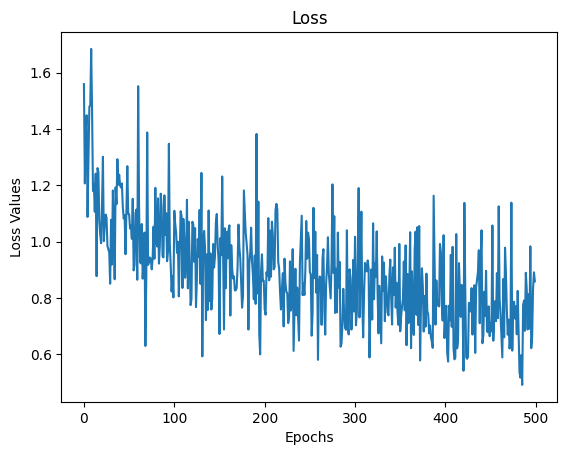

 Accuracy (short,medium,long): 
 56.5217 , 60.8696, 58.6957
 Precision (short,medium,long): 
 74.2857 , 77.7778, 61.3636
 Recall (short,medium,long): 
 70.2703 , 73.6842, 93.1034
 F1-score (short,medium,long): 
 72.2222 , 75.6757, 73.9726


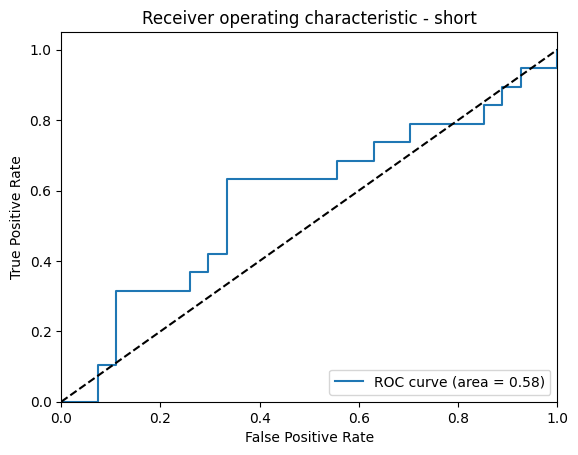

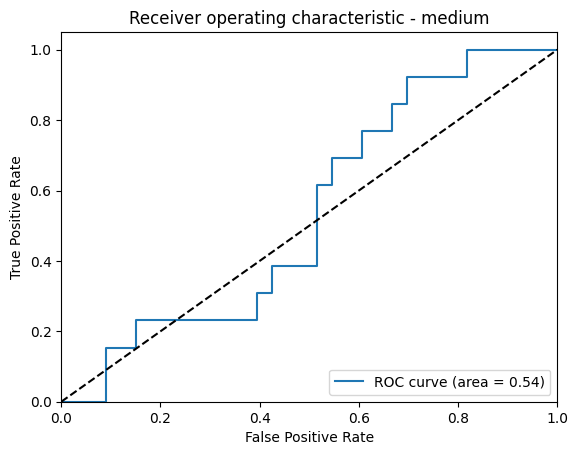

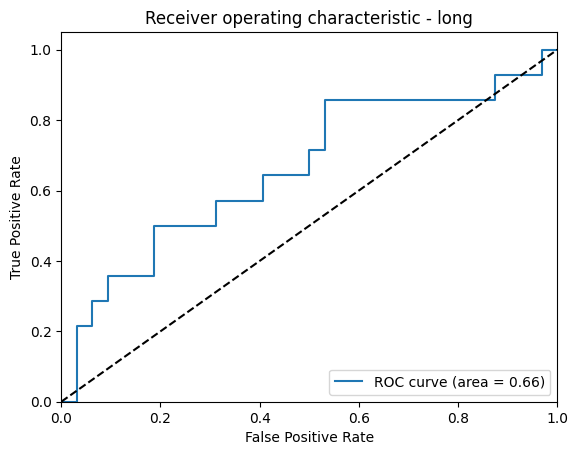

In [ ]:
# Train Survival Days Model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import gc
torch.cuda.empty_cache()
gc.collect()

# Hyper Parameters
BATCH_SIZE = 8
EPOCHS = 500
LR = 0.0001

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Functions
def show_roc(fpr, tpr, roc_auc, name="example"):
    fig, ax = plt.subplots(1, 1)
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {name}')
    ax.legend(loc="lower right")
    plt.show()


def calc_show_roc(results):

    fpr_s, tpr_s, _ = roc_curve(np.array(results['short']['real']).reshape(-1), np.array(results['short']['pred']).reshape(-1))
    roc_auc_s = auc(fpr_s, tpr_s)
    show_roc(fpr_s, tpr_s, roc_auc_s, name="short")

    fpr_m, tpr_m, _ = roc_curve(np.array(results['medium']['real']).reshape(-1), np.array(results['medium']['pred']).reshape(-1))
    roc_auc_m = auc(fpr_m, tpr_m)
    show_roc(fpr_m, tpr_m, roc_auc_m, name="medium")

    fpr_l, tpr_l, _ = roc_curve(np.array(results['long']['real']).reshape(-1), np.array(results['long']['pred']).reshape(-1))
    roc_auc_l = auc(fpr_l, tpr_l)
    show_roc(fpr_l, tpr_l, roc_auc_l, name="long")

def train(model, epochs=1, training_loader=None, loss_fn=None, device=None,
          optimizer: torch.optim.Optimizer = None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        tq_dl = tqdm(training_loader)
        for idx, (image, mask) in enumerate(tq_dl):
            image, mask = image.to(device), mask.to(device)
            # forward pass
            out = model(image.to(torch.float32))
            loss = loss_fn(out, mask.to(torch.float32))
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # optimize
            optimizer.step()

            tq_dl.set_description(f"At epoch [{epoch + 1}/{epochs}]")
            tq_dl.set_postfix(loss=loss.item())  # acc, ...
            losses[epoch] = loss.item()
    fig, ax = plt.subplots()
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Values')
    ax.plot(losses)
    # ax.legend()
    plt.show()


# do not give in the format - the format will be .pt
def save(model, path):
    torch.save(model.state_dict(), f"{path}.pt")

# Getting training dataset and model
train_dl = get_dl(train_data_sd, BATCH_SIZE,nw=1)
model = SurvivalPRED(6, 3).to(DEVICE)

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
# opt = optim.SGD(model.parameters(), lr=LR, momentum=0.9) 
# opt = optim.Adagrad(model.parameters(), lr=LR) 
# opt = optim.RMSprop(model.parameters(), lr=LR) 
opt = optim.Adam(model.parameters(), lr=LR) 

# Train the model 
train(model, epochs=EPOCHS, training_loader=train_dl, loss_fn=loss, device=DEVICE, optimizer=opt)

# # saving sample
# save(model,"/content/gdrive/MyDrive/ProjectDL/BraTS/3d_100e_adam_dice")
# print("saved the model...")

# validation
test_dl = get_dl(test_data_sd, BATCH_SIZE, False, nw=1)

with torch.no_grad():
    num_correct = {'short': 0, 'medium': 0, 'long': 0}
    num_false_positive = {'short': 0, 'medium': 0, 'long': 0}
    num_false_negative = {'short': 0, 'medium': 0, 'long': 0}

    num_pixels = {'short': 0, 'medium': 0, 'long': 0}
    dice_score = {'short': 0, 'medium': 0, 'long': 0}
    iou_score = {'short': 0, 'medium': 0, 'long': 0}
    results = {'short': {'real': [], 'pred': []}, 'medium': {'real': [], 'pred': []}, 'long': {'real': [], 'pred': []}}
    EPS = 1e-16
    correct = 0
    total = 0
    for images, masks in test_dl:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images.to(torch.float32))
        #print(outputs.data)
        original_preds = torch.sigmoid(outputs.data)

        for i in range(original_preds.shape[0]):
                short_real = masks[i,0].float()
                medium_real = masks[i,1].float()
                long_real = masks[i,2].float()

                short_pred = original_preds[i, 0].float()
                medium_pred = original_preds[i, 1].float()
                long_pred = original_preds[i, 2].float()

                # for auc_roc we need non-thresholded probabilities
                results['short']['pred'].append(short_pred.flatten().cpu().numpy())
                results['short']['real'].append(short_real.flatten().cpu().numpy())
                results['medium']['pred'].append(medium_pred.flatten().cpu().numpy())
                results['medium']['real'].append(medium_real.flatten().cpu().numpy())
                results['long']['pred'].append(long_pred.flatten().cpu().numpy())
                results['long']['real'].append(long_real.flatten().cpu().numpy())

                # Thresholding again
                short_pred = (short_pred >= 0.5).float()
                medium_pred = (medium_pred >= 0.5).float()
                long_pred = (long_pred >= 0.5).float()

                num_correct['short'] += (short_pred == short_real).sum()
                num_pixels['short'] += torch.numel(short_pred)
                if short_pred == 1 and short_real == 0:
                  num_false_positive['short'] += 1
                if short_pred == 0 and short_real == 1:
                  num_false_negative['short'] += 1  


                num_correct['medium'] += (medium_pred == medium_real).sum()
                num_pixels['medium'] += torch.numel(medium_pred)
                if medium_pred == 1 and medium_real == 0:
                  num_false_positive['medium'] += 1
                if medium_pred == 0 and medium_real == 1:
                  num_false_negative['medium'] += 1  


                num_correct['long'] += (long_pred == long_real).sum()
                num_pixels['long'] += torch.numel(long_pred)
                if long_pred == 1 and long_real == 0:
                  num_false_positive['long'] += 1
                if long_pred == 0 and long_real == 1:
                  num_false_negative['long'] += 1  



    # precision: correct true predicts / all true predicts -> TP / (TP + FP)
    precision = {'short': (num_correct['short'] / (num_correct['short'] + num_false_positive['short'])) * 100,
                 'medium': (num_correct['medium'] / (num_correct['medium'] + num_false_positive['medium'])) * 100,
                 'long': (num_correct['long'] / (num_correct['long'] + num_false_positive['long'])) * 100}

    # recall: correct true predicts / all true labels -> TP / (TP + FN)
    recall = {'short': (num_correct['short'] / (num_correct['short'] + num_false_negative['short'])) * 100,
              'medium': (num_correct['medium'] / (num_correct['medium'] + num_false_negative['medium'])) * 100,
              'long': (num_correct['long'] / (num_correct['long'] + num_false_negative['long'])) * 100}

    # f1 is actually the same as Dice Coefficient, or is it?
    f1 = {'short': 2 * precision['short'] * recall['short'] / (precision['short'] + recall['short']),
          'medium': 2 * precision['medium'] * recall['medium'] / (precision['medium'] + recall['medium']),
          'long': 2 * precision['long'] * recall['long'] / (precision['long'] + recall['long'])}

    items_size = original_preds.shape[0] * len(test_dl)


    print(
        f" Accuracy (short,medium,long): \n {num_correct['short'] / num_pixels['short'] * 100:.4f} , {num_correct['medium'] / num_pixels['medium'] * 100:.4f}, {num_correct['long'] / num_pixels['long'] * 100:.4f}")

    print(
        f" Precision (short,medium,long): \n {precision['short']:.4f} , {precision['medium']:.4f}, {precision['long']:.4f}")
    print(
        f" Recall (short,medium,long): \n {recall['short']:.4f} , {recall['medium']:.4f}, {recall['long']:.4f}")
    print(
        f" F1-score (short,medium,long): \n {f1['short']:.4f} , {f1['medium']:.4f}, {f1['long']:.4f}")
    
    calc_show_roc(results)
